## Augment as Q Actor-Critic

In [7]:
import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from torch.distributions import Normal

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, NormalizeObservation

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [8]:
def create_env(env_name, num_envs):
  env = gym.vector.make(env_name, num_envs)
  env = RecordEpisodeStatistics(env)
  env = NormalizeObservation(env)
  return env

In [16]:
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')

In [40]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.linear1.weight.data.normal_(0, 1e-1)
        self.linear2.weight.data.normal_(0, 1e-1)
        self.linear3.weight.data.normal_(0, 1e-2)
    
    def forward(self, state):
        x = state
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return torch.tanh(x)
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(state_size + action_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 1)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.linear1.weight.data.normal_(0, 1e-1)
        self.linear2.weight.data.normal_(0, 1e-1)
        self.linear3.weight.data.normal_(0, 1e-2)
    
    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)        
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [41]:
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x

        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [42]:
class Memory:
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory = []
        self.position = 0

    def push(self, element):
        if len(self.memory) < self.buffer_size:
            self.memory.append(None)
        self.memory[self.position] = element
        self.position = (self.position + 1) % self.buffer_size

    def sample(self):
        return list(zip(*random.sample(self.memory, self.batch_size)))

    def __len__(self):
        return len(self.memory)

In [43]:
class Agent:
    def __init__(self, state_size, action_size, buffer_size, batch_size, gamma, tau):
         # Actor Network and Target Network
        self.actor = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)

        # Critic Network and Target Network
        self.critic = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # copy weights
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)

        self.noise = OUActionNoise(mu=np.zeros(action_size))
        
        self.memory = Memory(buffer_size, batch_size)
        self.gamma = gamma
        self.tau = tau
        
    def hard_update(self, target, network):
        for target_param, param in zip(target.parameters(), network.parameters()):
            target_param.data.copy_(param.data)
            
    def soft_update(self, target, network):
        for target_param, param in zip(target.parameters(), network.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)
            
    def learn(self, batch):
        
        state, action, reward, next_state, done = batch

        state = torch.tensor(state).to(device).float()
        next_state = torch.tensor(next_state).to(device).float()
        reward = torch.tensor(reward).to(device).float()
        action = torch.tensor(action).to(device).float()
        done = torch.tensor(done).to(device).int()
        
        # update critic
        next_action = self.actor_target(next_state)

        Q_target = self.critic_target(next_state, next_action).detach()
        Q_target = reward.unsqueeze(1) + (self.gamma*Q_target*((1-done).unsqueeze(1)))

        Q_estimate = self.critic(state, action)
        critic_loss = F.mse_loss(Q_estimate, Q_target)        
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # update actor
        
        action_prediction = self.actor(state)
        actor_loss = -self.critic(state, action_prediction).mean()
        
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # update actor_target and critic_target
        
        self.soft_update(self.critic_target, self.critic)
        self.soft_update(self.actor_target, self.actor)
        
    def act(self, state, noise = True):
        state =  torch.tensor(state).to(device).float()
        action = self.actor(state).cpu().data.numpy()
        noise = self.noise()
        action_prime = action + noise#torch.tensor(self.noise(), dtype=torch.float)
        np.clip(action_prime, -1, 1, out=action_prime)
        return action_prime
    
    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        if len(self.memory) >= self.memory.batch_size:
            self.learn(self.memory.sample())
        
    def save(self):
        torch.save(self.actor, "LunarLander_actor.pkl")
        torch.save(self.critic, "LunarLander_critic.pkl")
        

size of eche action = 2
size of state = 8
episode: 1, current reward: -164.07236121816436, mean reward: -164.07236121816436
episode: 2, current reward: -605.2544396032047, mean reward: -384.6634004106845
episode: 3, current reward: -685.2324135563857, mean reward: -484.8530714592516
episode: 4, current reward: -283.7428900060673, mean reward: -434.5755260959555
episode: 5, current reward: -497.3412445572815, mean reward: -447.12866978822075
episode: 6, current reward: -352.65467441417695, mean reward: -431.3830038925468
episode: 7, current reward: -439.17314537236257, mean reward: -432.49588124680616
episode: 8, current reward: -528.6365405825923, mean reward: -444.5134636637794
episode: 9, current reward: -395.70614246552685, mean reward: -439.09042797508465
episode: 10, current reward: -476.5346698244503, mean reward: -442.8348521600213
episode: 11, current reward: -425.5257848999859, mean reward: -441.2613005909272
episode: 12, current reward: 13.952600464241897, mean reward: -403.3

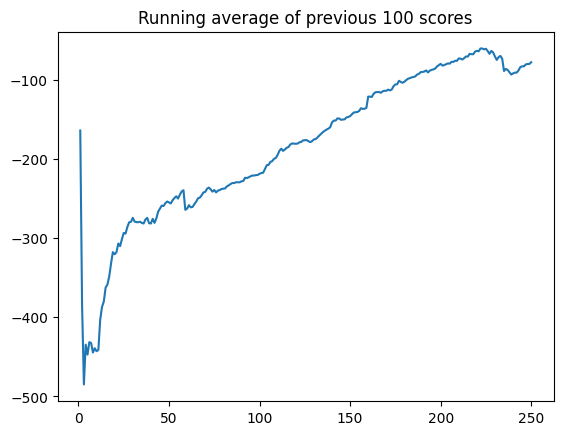

In [44]:
env = gym.make("LunarLanderContinuous-v2")
np.random.seed(9)
env.seed(9)

action_size = env.action_space.shape[0]
print(f'size of eche action = {action_size}')
state_size = env.observation_space.shape[0]
print(f'size of state = {state_size}')
BUFFER_SIZE = int(1e6)  
BATCH_SIZE = 64
GAMMA = 0.99            
TAU = 1e-3                    
EPISODES = 250
def ddpg(episodes):
    agent = Agent(state_size = state_size, action_size = action_size,
              buffer_size = BUFFER_SIZE, batch_size = BATCH_SIZE,
              gamma = GAMMA, tau = TAU)
    reward_list = []
    mean_reward = -20000
    for i in range(episodes):
        state = env.reset()
        agent.noise.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            total_reward +=reward
            state = next_state
            
        reward_list.append(total_reward)
        print(f"episode: {i+1}, current reward: {total_reward}, mean reward: {np.mean(reward_list[-100:])}")
            
            
    x = [i+1 for i in range(EPISODES)]
    plot_learning_curve(x, reward_list)
    return reward_list, agent

rewards, agent = ddpg(EPISODES)    

In [46]:
def show_video_of_model(agent: Agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="videos/ll_cont/{}_cat.mp4".format(env_name))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        
        action = agent.act(state)

        state, reward, done, _ = env.step(action)        
    env.close()

show_video_of_model(agent, 'LunarLanderContinuous-v2')